In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import CONFIG1
import s3fs
import pandas as pd
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
from cvxpy import SolverError
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

In [2]:
def load_sys(n, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    id = meta['ID'][n]
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(id), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, id)
    return df

In [3]:
n = np.random.randint(642) #80
df = load_sys(n, local=False)

457 40592


In [4]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2015-09-16 2017-07-02


In [5]:
end - start

Timedelta('655 days 00:00:00')

In [6]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
ics = IterativeClearSky(D)

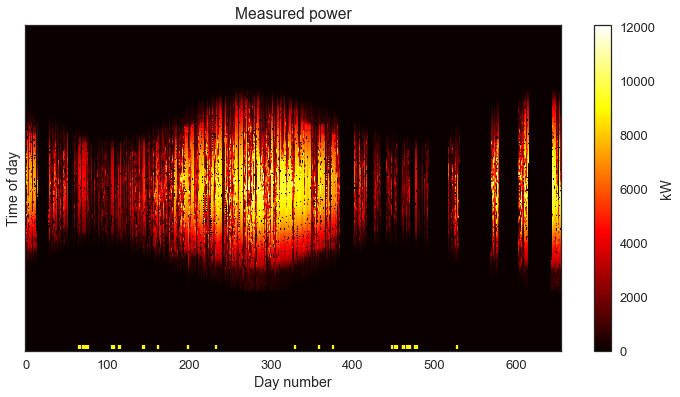

In [7]:
_ = ics.plot_D(show_days=True)

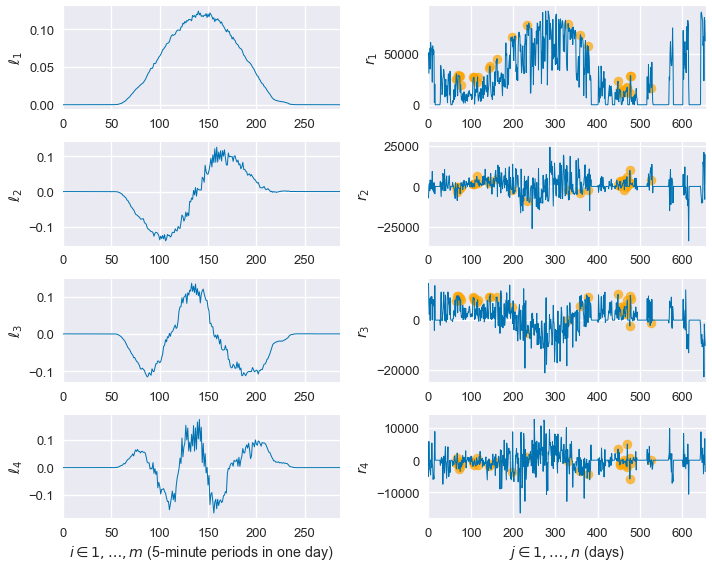

In [8]:
_ = ics.plot_singular_vectors(show_days=True)

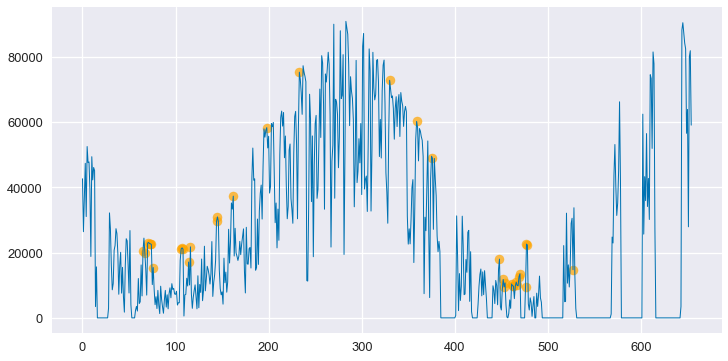

In [9]:
_ = ics.plot_energy()

In [10]:
ics.minimize_objective(**CONFIG1)

starting at 913652968.049 [757257.4085232283, 4462.600525831808, 741404019.4487666, 171487228.5911795]
iteration 1: 7796331.511 [7796331.511       0.          0.          0.   ]
Caution: residuals increased
iteration 2: 541094.881 [519192.508   2301.331  19601.042      0.   ]
iteration 3: 496970.614 [477019.798   1780.777  18170.039      0.   ]
iteration 4: 493868.147 [474296.48    1809.303  17762.364      0.   ]
iteration 5: 492208.536 [472531.949   1829.383  17847.205      0.   ]
Minimization complete in 0.56 minutes


In [11]:
print(np.round((
    ics.residuals_median,
    ics.residuals_variance,
    ics.residual_l0_norm
), 3), ics.isProblemStatusError, ics.isSolverError, ics.f1Increase, ics.objIncrease)

[ 0.195  0.359 65.629] False False True False


Here is the estimated degradation rate (year on year energy-yield) for the system:

In [12]:
ics.beta.value

array(0.04284204)

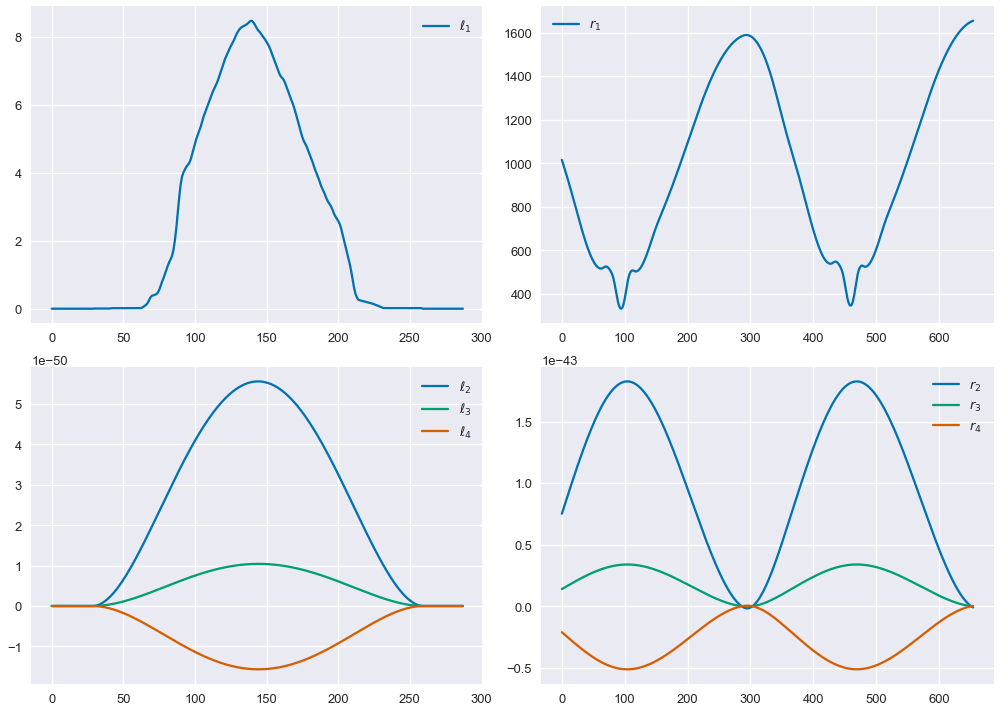

In [13]:
_ = ics.plot_LR()

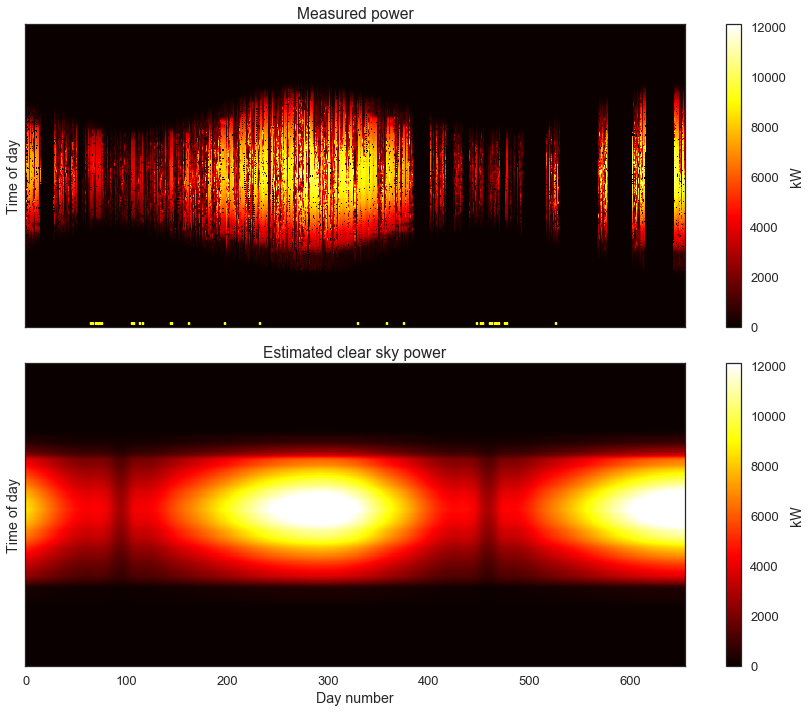

In [14]:
_ = ics.plot_measured_clear(figsize=(12, 10), show_days=True)

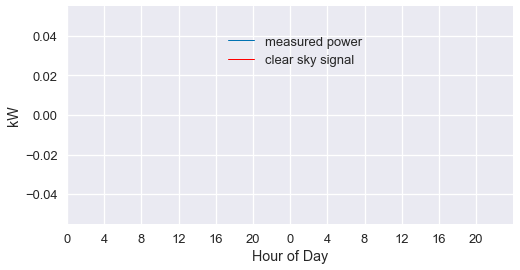

In [15]:
_ = ics.ts_plot(739)

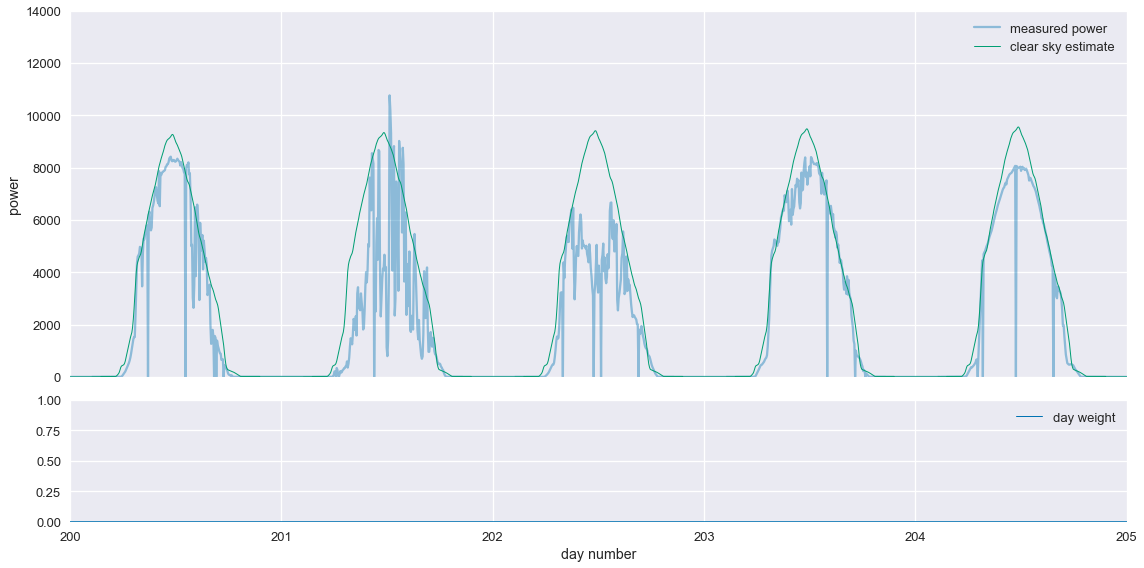

In [16]:
_ = ics.ts_plot_with_weights(200)

## Extra notes and scratch work

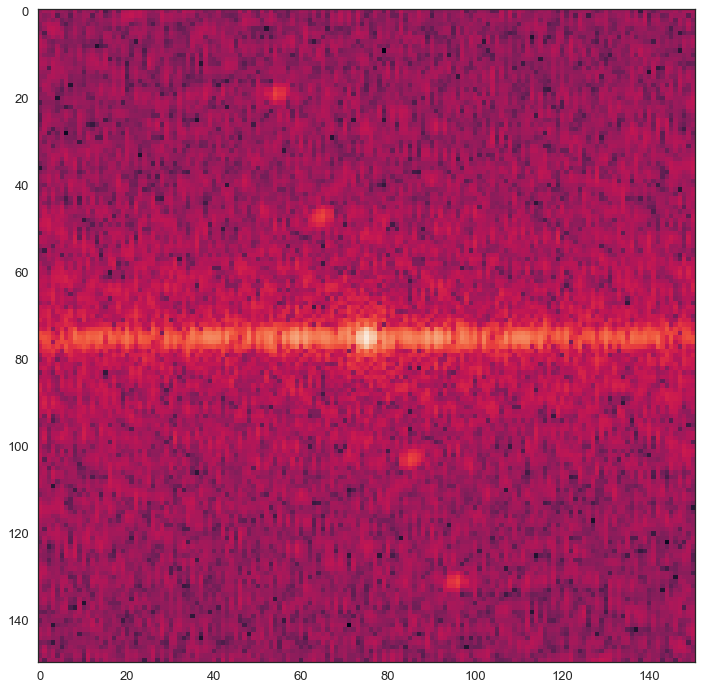

In [17]:
FS = fft2(D)
with sns.axes_style("white"):
    m, n = D.shape
    i = int(m / 2 - 75)
    j = int(n / 2 - 75)
    plt.figure(figsize=(12,12))
    plt.imshow(np.log(np.abs(np.fft.fftshift(FS)[i:-i, j:-j])**2))

In [18]:
fltr = np.zeros_like(D, dtype=np.float)
m, n = D.shape
c = (m // 2, n // 2)
r = 25
if m % 2 == 0:
    di = 0
else:
    di = 1
if n % 2 == 0:
    dj = 0
else:
    dj = 1
y, x = np.ogrid[-c[0]:c[0]+di, -c[1]:c[1]+dj]
mask = x ** 2 + y ** 2 <= r ** 2
fltr[mask] = 1
FS_filtered = fftshift(np.multiply(fftshift(FS), fltr))
D_filtered = np.abs(ifft2(FS_filtered))

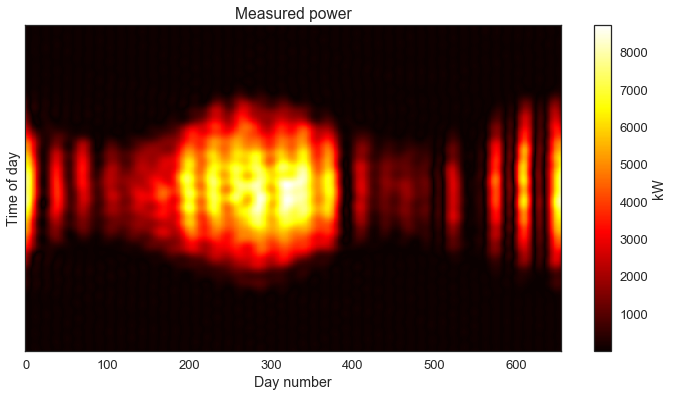

In [19]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(D_filtered, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')